In [5]:
#Import Packages

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import networkx as nx
import torch
import kornia
import scipy.sparse
import os
from scipy.sparse.linalg import spsolve, cg
np.set_printoptions(threshold=np.inf)

import tensorly as tl
from numpy.linalg import matrix_power

Consider the directed graph $DG$. 

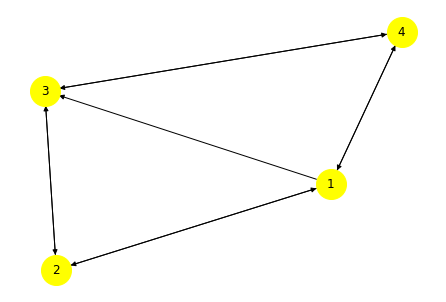

In [6]:
DG = nx.DiGraph()
DG.add_edges_from([(1,2), (2,1), (2,3), (3,2), (3,4), (4,3), (4,1), (1,4), (1,3)])
nx.draw(DG, node_size = 900, node_color = 'yellow', with_labels = True)

The incidence matrix $DG$ is a function that maps vertices to edges. The incidence matrix for this example is
$$ S =
\begin{bmatrix}
% 1   2   3   4  
 -1 & 1 & 0 & 0 \\ 
 0 & -1 & 1 & 0 \\
 0 & 0 & -1 & 1 \\
 -1 & 0 & 0 & 1 \\
 1 & -1 & 0 & 0 \\ 
 0 & 1 & -1 & 0 \\
 0 & 0 & 1 & -1 \\
 1 & 0 & 0 & -1 \\
 -1 & 0 & 1 & 0 \\
\end{bmatrix}
$$
where the columns represent vertices and the rows represent edges.

A weight matrix maps edges to edges and can be represented for this graph as
$$
W = \begin{bmatrix}
w_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & w_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & w_3 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & w_4 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & w_5 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & w_6 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & w_7 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & w_8 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & w_9 \\
\end{bmatrix}.
$$ 
The Laplacian in this case is represented as $L = S^T W S$. If $W$ is an identity matrix then $S^T S = L = V\Sigma^2 V^T$ and $S = U \Sigma V^T$.

If each vertex is represented by a vector, the weight matrix would be
$$
W = \begin{bmatrix}
[W_1] & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & [W_2] & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & [W_3] & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & [W_4] & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & [W_5] & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & [W_6] & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & [W_7] & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & [W_8] & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & [W_9] \\
\end{bmatrix}
$$ where each $W_n$ is a square $n\times n$ matrix in which $n$ is the size of the vertex vectors. Furthermore, each $W_i$ should be positive definite.

Probability matrix and a random walk on $DG$ is

$$P = 
\begin{bmatrix}
P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & 0 \\
0 & P_{32} & P_{33} & P_{34} \\
P_{41} & 0 & P_{43} & P_{44} \\
\end{bmatrix}
$$

where each row adds to 1. A natural random walk means each row has the same probability entries. Hence,

$$P_{natural} = 
\begin{bmatrix}
1/4 & 1/4 & 1/4 & 1/4 \\
1/3 & 1/3 & 1/3 & 0 \\
0 & 1/3 & 1/3 & 1/3 \\
1/3 & 0 & 1/3 & 1/3 \\
\end{bmatrix}
$$

Adjacency matrix for a random walk:

$$A = 
\begin{bmatrix}
1 & 1 & 1 & 1 \\
1 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
1 & 0 & 1 & 1 \\
\end{bmatrix}
$$

Degree matrix for a random walk:

$$D = 
\begin{bmatrix}
4 & 0 & 0 & 0 \\
0 & 3 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 3 \\
\end{bmatrix}
$$
These degree matrices are one higher than expected since each step includes the possibility of staying at the node.

Thus, we get a Laplacian matrix 
$$D - A =
\begin{bmatrix}
3 & -1 & -1 & -1 \\
-1 & 2 & -1 & 0 \\
0 & -1 & 2 & -1 \\
-1 & 0 & -1 & 2 \\
\end{bmatrix}.
$$

To get the matrix $P_{natural}$ we note that $P = D^{-1}A = D^{-1}(D-L) = I - D^{-1}L$.

In [7]:
Pnat = np.array([[1/4, 1/4, 1/4, 1/4],
                 [1/3, 1/3, 1/3, 0],
                 [0, 1/3, 1/3, 1/3],
                 [1/3, 0, 1/3, 1/3]])

A = np.array([[1, 1, 1, 1],
                 [1, 1, 1, 0],
                 [0, 1, 1, 1],
                 [1, 0, 1, 1]])

D = np.array([[4,0,0,0],
                 [0,3,0,0],
                 [0,0,3,0],
                 [0,0,0,3]])
Dinv = np.array([[1/4,0,0,0],
                 [0,1/3,0,0],
                 [0,0,1/3,0],
                 [0,0,0,1/3]])
L = D-A

In [8]:
# returns Pnat
Dinv @ A, np.eye(4) - Dinv @ L

(array([[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.33333333, 0.33333333, 0.33333333, 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.        , 0.33333333, 0.33333333]]),
 array([[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.33333333, 0.33333333, 0.33333333, 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.        , 0.33333333, 0.33333333]]))

We can also obtain the Laplacian matrix from the probability matrix. Note $L = D(I-P)$.

In [9]:
# returns L
D @ (np.eye(4) - Pnat)

array([[ 3., -1., -1., -1.],
       [-1.,  2., -1.,  0.],
       [ 0., -1.,  2., -1.],
       [-1.,  0., -1.,  2.]])

Hence we have developed a relationship between the Laplacian and probability transition matrix.

Note that $P_{natural}$ is row stochastic meaning all rows sum to 1.

In [20]:
Pnat

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

In [10]:
Pnat.sum(axis = 1)

array([1., 1., 1., 1.])

Hence, the columns of $P_{natural}$ will converge when high powers of the matrix are taken.

In [30]:
res = np.linalg.matrix_power(Pnat, 100000)
res

array([[0.21052632, 0.23684211, 0.31578947, 0.23684211],
       [0.21052632, 0.23684211, 0.31578947, 0.23684211],
       [0.21052632, 0.23684211, 0.31578947, 0.23684211],
       [0.21052632, 0.23684211, 0.31578947, 0.23684211]])

We get what seems to be the same eigenvector in each row of the resulting matrix.

In [21]:
Pnat.T @ res[0,:]

array([0.21052632, 0.23684211, 0.31578947, 0.23684211])

For a vector valued graph, our probability matrix will be a matrix of matrices. We check to see if the same principle applies.

In [22]:
P2 = np.kron(Pnat, np.eye(2))
P2

array([[0.25      , 0.        , 0.25      , 0.        , 0.25      ,
        0.        , 0.25      , 0.        ],
       [0.        , 0.25      , 0.        , 0.25      , 0.        ,
        0.25      , 0.        , 0.25      ],
       [0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
        0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
        0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.33333333,
        0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.33333333, 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.33333333, 0.        , 0.33333333]])

In [32]:
res2 = np.linalg.matrix_power(P2, 1000000)
res2

array([[0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211]])

Even if we change a few of the matrices to allow for mixing at a node, high powers of the matrix still converge.

In [24]:
P2[0,1] = 0.05 
P2[0,0] = 0.2
P3 = P2
P3.sum(axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
res3 = np.linalg.matrix_power(P3, 500)
res3

array([[0.00121253, 0.20931379, 0.00143668, 0.23540543, 0.00192045,
        0.31386902, 0.00143668, 0.23540543],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.00127054, 0.20925578, 0.00150541, 0.2353367 , 0.00201233,
        0.31377715, 0.00150541, 0.2353367 ],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.00129007, 0.20923625, 0.00152855, 0.23531356, 0.00204326,
        0.31374621, 0.00152855, 0.23531356],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211],
       [0.00127054, 0.20925578, 0.00150541, 0.2353367 , 0.00201233,
        0.31377715, 0.00150541, 0.2353367 ],
       [0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211]])

In [26]:
res3[0,:], res3[1,:]

(array([0.00121253, 0.20931379, 0.00143668, 0.23540543, 0.00192045,
        0.31386902, 0.00143668, 0.23540543]),
 array([0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
        0.31578947, 0.        , 0.23684211]))

In [27]:
P3.T @ res3[0,:]

array([0.00120029, 0.20932602, 0.00142218, 0.23541993, 0.00190107,
       0.31388841, 0.00142218, 0.23541993])

In [19]:
P3.T @ res3[1,:]

array([0.        , 0.21052632, 0.        , 0.23684211, 0.        ,
       0.31578947, 0.        , 0.23684211])

We actually appear to get two eigenvectors from raising the probability transition matrix a sufficient number of times...